# Overview


# Problem Statement

# Motivation

- Target column to be predicted: count
- Given 8 independent features -> datetime, season, holiday, workday,weather, temp, atemp, humidity, windspeed
 >- casual and registered comprises of split-up of the target column

# Importing Necessary Modules and Getting data from Kaggle

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2
  Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.0.0
    Uninstalling setuptools-57.0.0:
      Successfully uninstalled setuptools-57.0.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached MarkupSafe-2.1.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22

In [3]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "vinayakmodgil"
kaggle_key = "1e1bbda15ed41ffcf7f5d59cbcf43c00"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("always")

from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('autogluon')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('autogluon')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lo

# Data Knowledge
- You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
## Feature Description

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
  >- 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
  >- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
  >- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  >- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [8]:
data = pd.read_csv("train.csv", parse_dates=True, index_col="datetime")
test = pd.read_csv("test.csv", parse_dates=True, index_col="datetime")
submission = pd.read_csv("sampleSubmission.csv")

In [9]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
print("train data shape: ", data.shape)
print("test data shape: ", test.shape)

train data shape:  (10886, 11)
test data shape:  (6493, 8)


## Data Summary

In [11]:
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


There are 0 null values in the training data which means that no rows/columns need to be dropped

# Exploratory Data Analysis

## Barplots for discrete values vs bike rentals 

In [13]:
season_dict = {1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}
weather_dict = {1:"Clear", 2:"Mist+Cloudy", 3:"Light Snow", 4:"Heavy Rain"}
data["season"] = data["season"].map(season_dict)
data["weather"] = data["weather"].map(weather_dict)

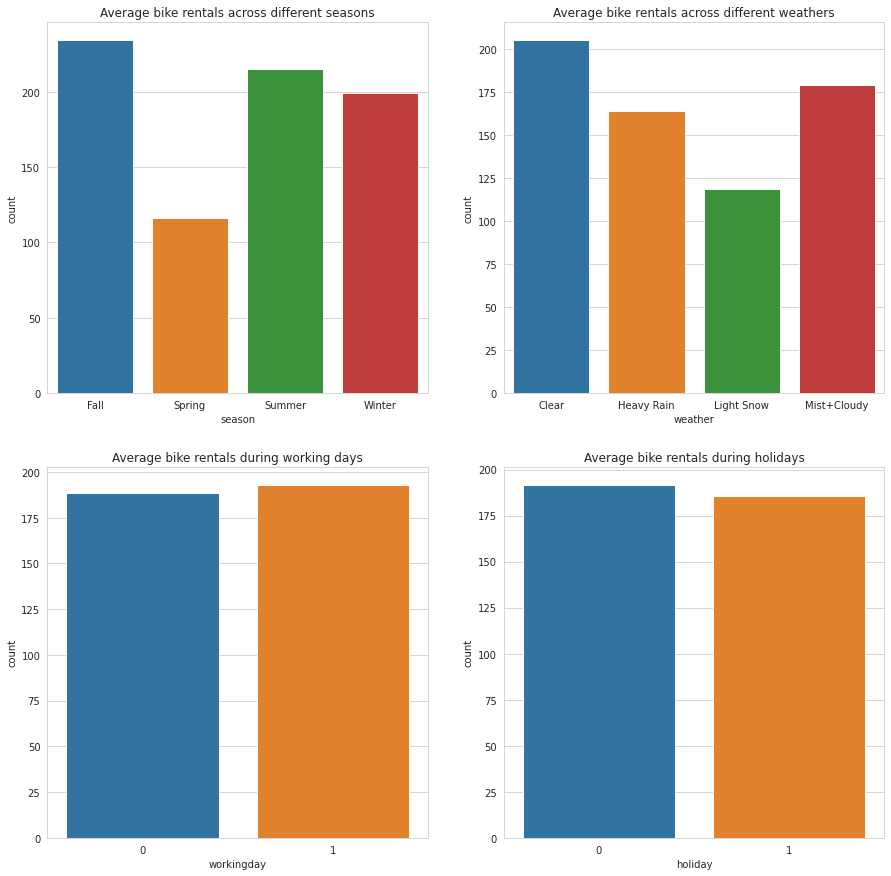

In [14]:
#Create plots for different independent features
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15, 15)) 
sns.barplot(data=pd.DataFrame(data.groupby("season")["count"].mean()).reset_index(),x="season", y="count", ax = axes[0][0])
axes[0][0].set_title("Average bike rentals across different seasons")

sns.barplot(data=pd.DataFrame(data.groupby("weather")["count"].mean()).reset_index(), x="weather", y="count", ax = axes[0][1])
axes[0][1].set_title("Average bike rentals across different weathers")

sns.barplot(data=pd.DataFrame(data.groupby("workingday")["count"].mean()).reset_index(), x="workingday", y="count", ax=axes[1][0]) 
axes[1][0].set_title("Average bike rentals during working days")

sns.barplot(data=pd.DataFrame(data.groupby("holiday")["count"].mean()).reset_index(), x="holiday", y="count", ax=axes[1][1])
axes[1][1].set_title("Average bike rentals during holidays")

plt.show()

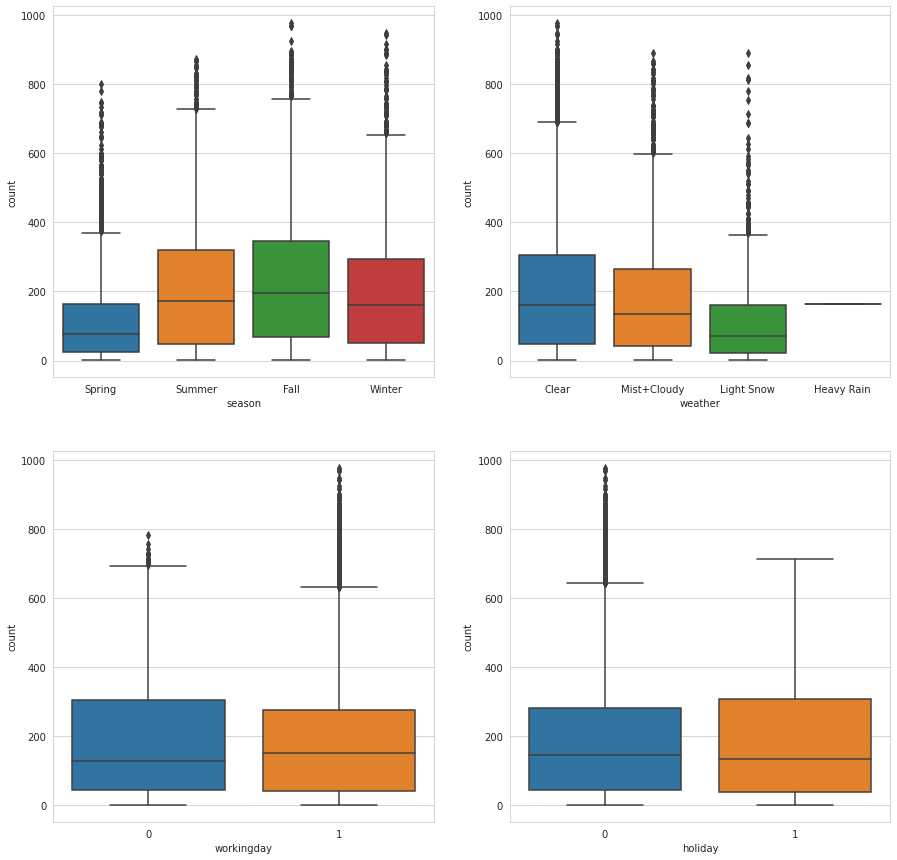

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.boxplot(data=data, x="season", y="count", ax=ax[0][0])

sns.boxplot(data=data, x="weather", y="count", ax=ax[0][1])

sns.boxplot(data=data, x="workingday", y="count", ax=ax[1][0])

sns.boxplot(data=data, x="holiday", y="count", ax=ax[1][1])
plt.show()

## Plotting continuous values with the target variable

In [16]:
data["windspeed"].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64

In [17]:
# fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# sns.pointplot(data=data, x="windspeed", y="count", hue="workingday",ax = ax[0])
# ax[0].set_title("Bike rental across windspeed for working and non working days") 


### Relationship of the target variable with Temperature

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


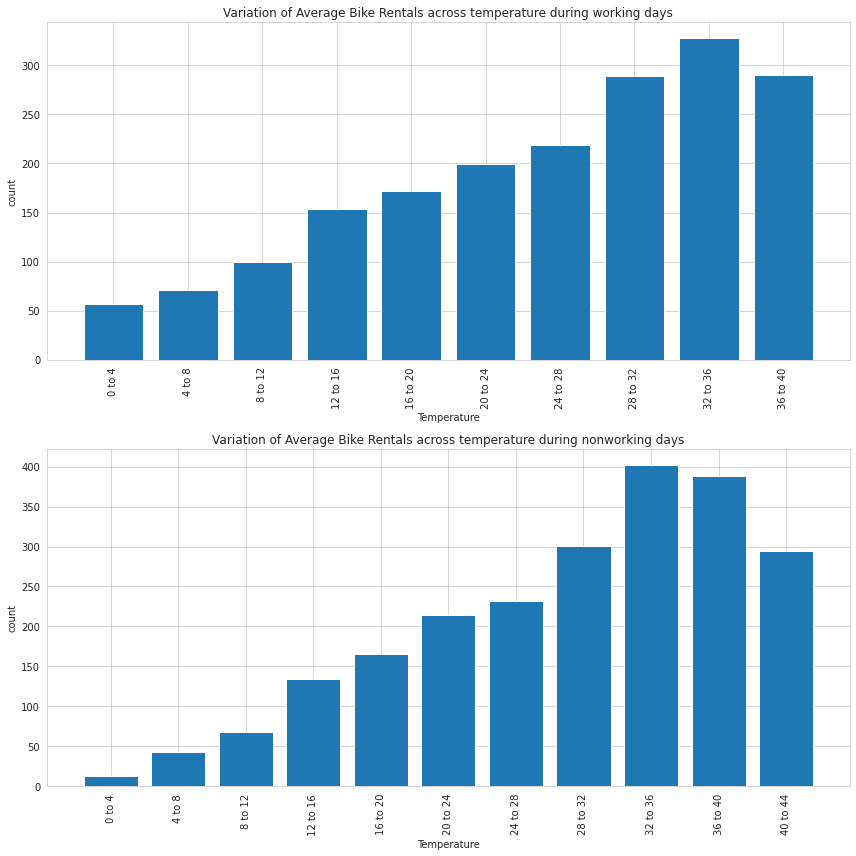

In [18]:
#Code adapted and redesigned from a Github Link

#Initialize a variable bin_size 
bin_size = 4

# Create barplot for average bike rentals during working days

data_w = data.loc[data["workingday"] == 1]

data_w["temp_bin"] = data_w["temp"] //bin_size
data_w_mean_group = data_w.groupby("temp_bin")["count"].mean()

idx_w = range(len(data_w_mean_group))

labels_w = [f"{bin_size*i} to {bin_size*(i+1)}" for i in idx_w]

fig, ax = plt.subplots(nrows=2, figsize=(12, 12))
ax[0].bar(x=idx_w, height=data_w_mean_group)
ax[0].set_xticks(idx_w, labels_w, rotation=90)
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("count")
ax[0].set_title("Variation of Average Bike Rentals across temperature during working days") 

# Create barplot for average bike rentals during nonworking days

data_nw = data.loc[data["workingday"] !=1]
data_nw["temp_bin"] = data_nw["temp"]//bin_size

data_nw_mean_group = data_nw.groupby("temp_bin")["count"].mean()

idx_nw = range(len(data_nw_mean_group))

labels_nw = [f"{bin_size*i} to {bin_size*(i+1)}" for i in idx_nw]

ax[1].bar(x=idx_nw, height=data_nw_mean_group)
ax[1].set_xticks(idx_nw, labels_nw, rotation=90)
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel("count")
ax[1].set_title("Variation of Average Bike Rentals across temperature during nonworking days") 

plt.tight_layout()
plt.show()



## Relationship of Target Variable with Humidity and Windspeed

In [19]:
data["humidity"].nunique()

89

In [20]:
print((data["humidity"].min(), data["humidity"].max()))

(0, 100)


<AxesSubplot:xlabel='humidity', ylabel='count'>

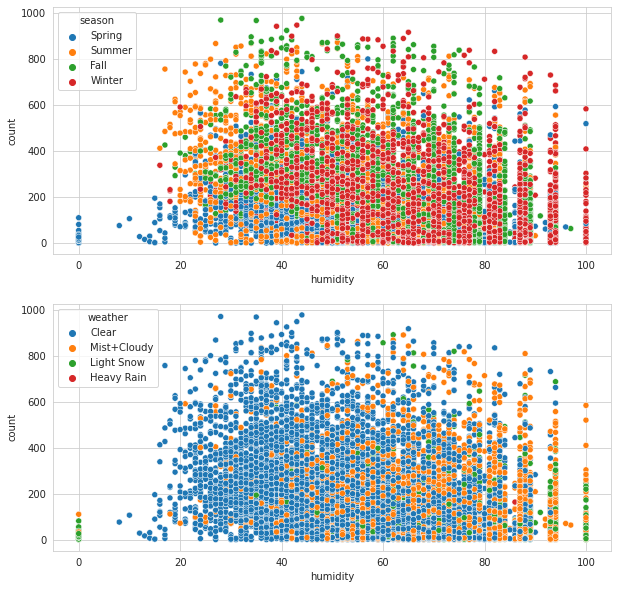

In [21]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
sns.scatterplot(data=data, x="humidity", y="count", hue="season", ax=ax[0])
sns.scatterplot(data=data, x="humidity", y="count", hue="weather", ax=ax[1])

<AxesSubplot:xlabel='windspeed', ylabel='count'>

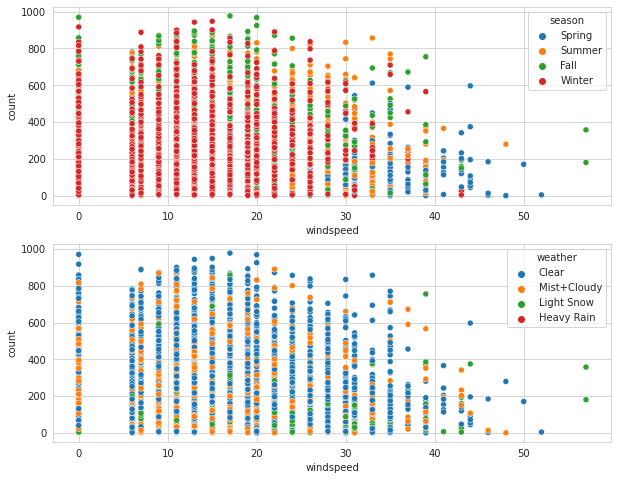

In [22]:
fig,ax = plt.subplots(nrows=2, figsize=(10,8))
sns.scatterplot(data=data, x="windspeed", y="count", hue="season", ax=ax[0])
sns.scatterplot(data=data, x="windspeed", y="count", hue="weather", ax=ax[1])

# Feature Engineering

In [23]:
data["day"] = [x.weekday() for x in data.index]
test["day"] = [x.weekday() for x in test.index]

data["hour"] = [x.hour for x in data.index]
test["hour"] = [x.hour for x in test.index]

data["year"] = [x.year for x in data.index]
test["year"] = [x.year for x in test.index]

data["month"] = [x.month for x in data.index]
test["month"] = [x.month for x in test.index]

day_dict = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}
month_dict = {1:"Jan", 2: "Feb", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}

data["dayname"] = data["day"].map(day_dict)
test["dayname"] = data["day"].map(day_dict)

data["monthname"] = data["month"].map(month_dict)
test["monthname"] = data["month"].map(month_dict)

In [24]:
data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,hour,year,month,dayname,monthname
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0000,3,13,16,5,0,2011,1,Sat,Jan
2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,8,32,40,5,1,2011,1,Sat,Jan
2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,5,27,32,5,2,2011,1,Sat,Jan
2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,3,10,13,5,3,2011,1,Sat,Jan
2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,0,1,1,5,4,2011,1,Sat,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336,2,19,2012,12,Wed,Dec
2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241,2,20,2012,12,Wed,Dec
2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168,2,21,2012,12,Wed,Dec


## Variation of bike rentals with respect to time (EDA 2.0)

### Hourly Variation

<AxesSubplot:xlabel='hour', ylabel='count'>

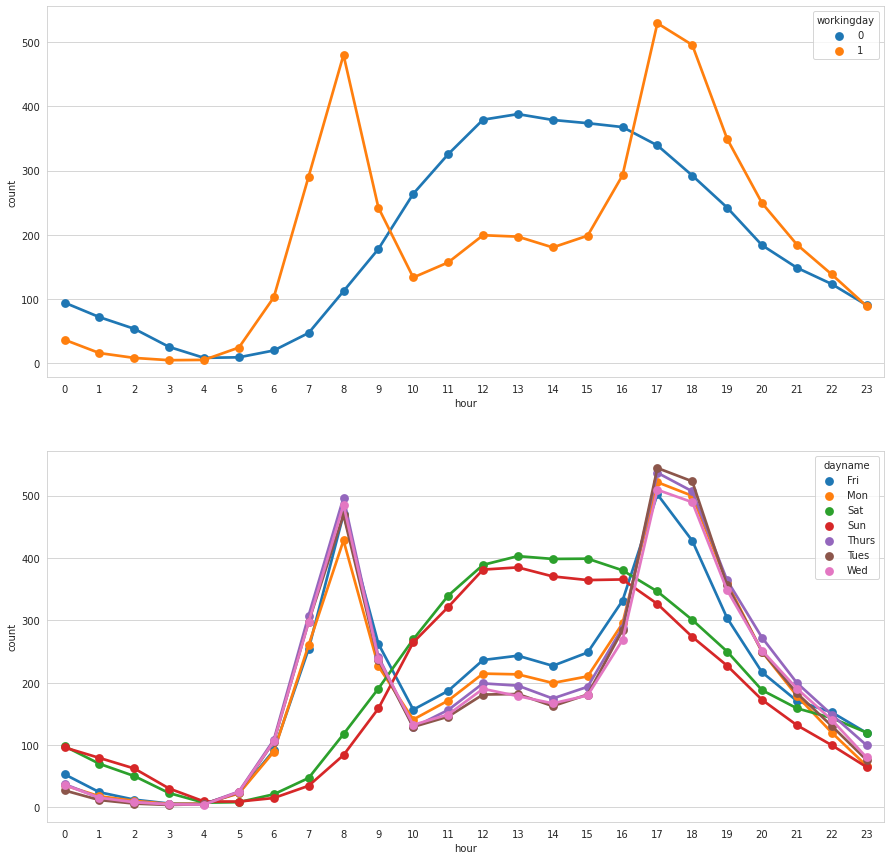

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 15))

data_mean_hour_work_group = pd.DataFrame(data.groupby(["hour", "workingday"])["count"].mean()).reset_index()
sns.pointplot(data=data_mean_hour_work_group, x="hour", y="count", ax=ax[0], hue="workingday")

hue_order = ["Mon", "Tue", "Wed", "Thurs", "Fri", "Sat", "Sun"]

data_mean_hour_day_group = pd.DataFrame(data.groupby(["hour", "dayname"])["count"].mean()).reset_index()
sns.pointplot(data=data_mean_hour_day_group, x="hour", y="count", hue="dayname", ax=ax[1])

### Daily/Weekly/Monthly Variation of average bike rentals

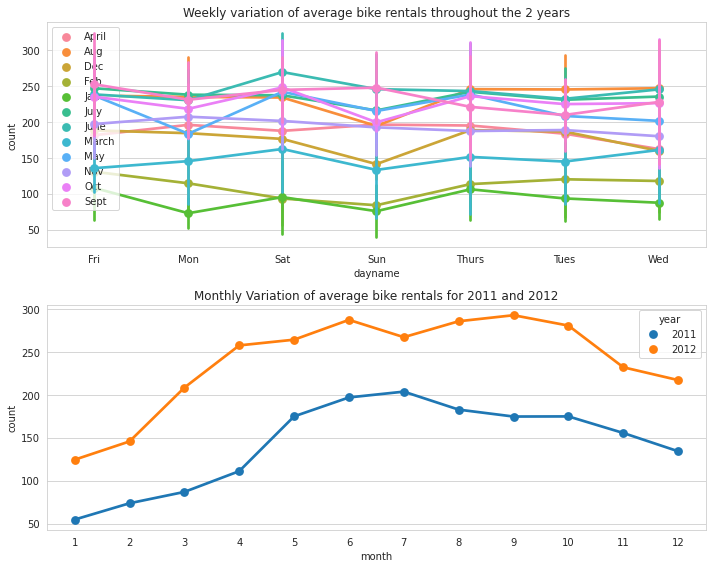

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
data_month_group = pd.DataFrame(data.groupby(["month", "year"])["count"].mean()).reset_index() 
sns.pointplot(data=data_month_group, x="month", y="count",hue="year", ax=ax[1])
ax[1].set_title("Monthly Variation of average bike rentals for 2011 and 2012")

data_day_group = pd.DataFrame(data.groupby(["monthname", "dayname", "year"])["count"].mean()).reset_index()
sns.pointplot(data=data_day_group, x="dayname", y="count", hue="monthname", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title("Weekly variation of average bike rentals throughout the 2 years")
plt.tight_layout()

## Data Preprocessing for Modeling

In [27]:
from sklearn.preprocessing import StandardScaler

data_cpy = data.copy()

dict_inv_season = {"Spring":1, "Summer":2, "Fall":3, "Winter":4}
dict_inv_weather = {"Clear":1, "Mist+Cloudy":2, "Light Snow":3, "Heavy Rain":4}

data_cpy["season"] = data_cpy["season"].map(dict_inv_season)
data_cpy["weather"] = data_cpy["weather"].map(dict_inv_weather)


In [28]:
data_cpy

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,hour,year,month,dayname,monthname
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,5,0,2011,1,Sat,Jan
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,5,1,2011,1,Sat,Jan
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,5,2,2011,1,Sat,Jan
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,5,3,2011,1,Sat,Jan
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,5,4,2011,1,Sat,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2,19,2012,12,Wed,Dec
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2,20,2012,12,Wed,Dec
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2,21,2012,12,Wed,Dec


In [29]:
data_cpy.drop(["dayname", "monthname"], axis=1, inplace=True)
data_cpy.drop(["registered", "casual"], axis=1, inplace=True)

In [30]:
print(data_cpy.columns)
print(test.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'day', 'hour', 'year', 'month'],
      dtype='object')
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'day', 'hour', 'year', 'month', 'dayname',
       'monthname'],
      dtype='object')


In [31]:
test.drop(["dayname", "monthname"], axis=1, inplace=True)

In [32]:
test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,hour,year,month
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,0,2011,1
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,1,2011,1
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,2,2011,1
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,2011,1
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,4,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,0,19,2012,12
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,0,20,2012,12
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,0,21,2012,12


In [33]:
X = data_cpy.drop("count", axis=1)
y = data_cpy["count"]

In [34]:
data_cpy

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,day,hour,year,month
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,5,0,2011,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,5,1,2011,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,5,2,2011,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,5,3,2011,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,5,4,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2,19,2012,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2,20,2012,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2,21,2012,12


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
ss = StandardScaler()

scaled_X_train = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns, index=X_train.index) 
scaled_X_test = pd.DataFrame(ss.transform(test), columns = test.columns, index=test.index)

In [38]:
scaled_X_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,hour,year,month
datetime,,,,,,,,,,,,
2011-09-03 12:00:00,0.449782,-0.174386,-1.457184,-0.657591,1.099889,1.064798,-0.040564,0.261225,0.986700,0.064375,-1.002530,0.725437
2012-08-02 17:00:00,0.449782,-0.174386,0.686255,-0.657591,1.732925,1.781054,-0.509316,0.503481,-0.011173,0.785468,0.997477,0.435861
2012-04-12 06:00:00,-0.444238,-0.174386,0.686255,-0.657591,-1.010231,-1.083971,0.167770,0.503481,-0.011173,-0.800937,0.997477,-0.722444
2011-06-19 19:00:00,-0.444238,-0.174386,-1.457184,-0.657591,1.205395,1.243862,0.011520,-0.467170,1.485637,1.073905,-1.002530,-0.143292
2012-02-03 04:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.263035,-0.092648,0.261225,0.487764,-1.089374,0.997477,-1.301596
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-15 13:00:00,1.343802,-0.174386,0.686255,2.523689,0.255841,0.259305,-0.092648,0.261225,-1.009046,0.208594,-1.002530,1.304589
2011-08-05 22:00:00,0.449782,-0.174386,0.686255,-0.657591,1.099889,1.064798,0.167770,0.261225,0.487764,1.506561,-1.002530,0.435861
2012-10-14 14:00:00,1.343802,-0.174386,-1.457184,-0.657591,0.888877,0.885734,-1.186403,1.838330,1.485637,0.352812,0.997477,1.015013


In [39]:
scaled_X_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,hour,year,month
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.442099,-0.300982,1.596074,-0.011173,-1.666248,-1.002530,-1.591172
2011-01-20 01:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.173798,-0.300982,-1.558950,-0.011173,-1.522029,-1.002530,-1.591172
2011-01-20 02:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.173798,-0.300982,-1.558950,-0.011173,-1.377811,-1.002530,-1.591172
2011-01-20 03:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.263035,-0.300982,-0.224101,-0.011173,-1.233592,-1.002530,-1.591172
2011-01-20 04:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.263035,-0.300982,-0.224101,-0.011173,-1.089374,-1.002530,-1.591172
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,-1.338258,-0.174386,0.686255,0.933049,-1.221242,-1.263035,-0.092648,-0.224101,-1.507983,1.073905,0.997477,1.594165
2012-12-31 20:00:00,-1.338258,-0.174386,0.686255,0.933049,-1.221242,-1.263035,-0.092648,-0.224101,-1.507983,1.218124,0.997477,1.594165
2012-12-31 21:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.263035,-0.092648,-0.224101,-1.507983,1.362342,0.997477,1.594165


# Data Modeling

## Baseline Linear Model

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score

In [41]:
linreg = LinearRegression()
linreg.fit(scaled_X_train, y_train)
y_train_preds = linreg.predict(scaled_X_train)
y_test = linreg.predict(scaled_X_test)
print("R2 Score: ", linreg.score(scaled_X_train, y_train))
print("Root Mean Squared Error:", mean_squared_error(y_train_preds, y_train)**0.5)

R2 Score:  0.38784852616666443
Root Mean Squared Error: 141.4908804039342


## Linear Model 1 (Ridge) with hyperparameter tuning

In [42]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [43]:
params = {"alpha":[0.001, 0.01, 0.1, 1, 2, 4, 10], 
          "solver": ['auto', 'svd', 'saga']}

In [44]:
gcv_linear_model= GridSearchCV(Ridge(), param_grid=params, n_jobs=-1, cv=5)
gcv_linear_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 4, 10],
                         'solver': ['auto', 'svd', 'saga']})

In [45]:
gcv_linear_model.best_estimator_

Ridge(alpha=10)

In [46]:
ridge_linear_model = Ridge(alpha=10,solver="saga")
ridge_linear_model.fit(scaled_X_train, y_train)
ridge_linear_model.score(scaled_X_train, y_train)
y_train_preds = ridge_linear_model.predict(scaled_X_train)
y_test = ridge_linear_model.predict(scaled_X_test)

print("R2 Score: ", ridge_linear_model.score(scaled_X_train, y_train))
print("Root Mean Squared Error:", mean_squared_error(y_train_preds, y_train)**0.5)

R2 Score:  0.387846347473095
Root Mean Squared Error: 141.49113219210278


## Using AutoGluon library for bike rental prediction

In [47]:
predictor = TabularPredictor(label="count",
                             problem_type="regression",
                             eval_metric="r2").fit(train_data=data_cpy,
                                                   presets="best_quality",
                                                   time_limit = 600)
                                                                                             

No path specified. Models will be saved in: "AutogluonModels/ag-20230613_123136/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230613_123136/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu May 4 09:55:30 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2671.81 MB
	Train Data (Original)  Memory Usage: 1.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [48]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.965095      32.999338  507.345943                0.001433           0.534728            3       True         16
1     ExtraTreesMSE_BAG_L2   0.964730      32.229546  394.318951                0.908184           8.458891            2       True         14
2      WeightedEnsemble_L2   0.964686      30.388742  353.795430                0.001391           0.484434            2       True          9
3          CatBoost_BAG_L2   0.964228      31.367970  426.052343                0.046608          40.192283            2       True         13
4          LightGBM_BAG_L2   0.963596      31.451834  408.985393                0.130472          23.125334            2       True         11
5   RandomForestMSE_BAG_L2   0.963315      31.970794  413.632864                

/usr/local/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.5928431927811847,
  'KNeighborsDist_BAG_L1': 0.6179025465004329,

<AxesSubplot:xlabel='model'>

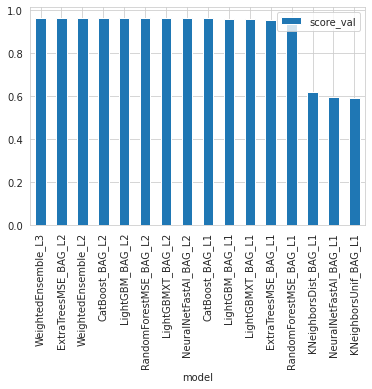

In [49]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [50]:
predictions = predictor.predict(test)
predictions.head()
predictions= predictions.reset_index()

In [51]:
predictions.describe()

,count
count,6493.000000
mean,189.868866
std,174.842957
min,1.953763
25%,45.720055
50%,146.115356
75%,279.826569
max,898.327209


In [52]:
predictions["count"].lt(0).sum().sum()

0

In [53]:
predictions["count"] = predictions["count"].clip(lower=0)
predictions["count"].nunique()

6491

### Submissions

In [54]:
submission["count"] = predictions["count"]
submission.to_csv("submission.csv", index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "second raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 531kB/s]
Successfully submitted to Bike Sharing Demand

In [56]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description                   status    publicScore  privateScore  
--------------  -------------------  ----------------------------  --------  -----------  ------------  
submission.csv  2023-06-13 12:42:49  second raw submission         pending                              
submission.csv  2023-06-12 16:35:16  xgb(wo hp tuning) submission  complete  0.52993      0.52993       
submission.csv  2023-06-12 15:57:34  Neural Net submission         complete  0.53373      0.53373       
submission.csv  2023-06-12 15:56:05  Neural Net submission         error                                


In [57]:
data_cpy

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,day,hour,year,month
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,5,0,2011,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,5,1,2011,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,5,2,2011,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,5,3,2011,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,5,4,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2,19,2012,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2,20,2012,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2,21,2012,12


### Feature Engineering 2.0

In [58]:
def temperature(x):
    if x <=10:
        return 0
    elif x >10 and x <=25:
        return 1
    else:
        return 2

def atemp(x):
    if x<=10:
        return 0
    elif x>10 and x <=25:
        return 1
    else:
        return 2
    

def humidity(x):
    if x <=30:
        return 0
    elif x>30 and x <=50:
        return 1
    else:
        return 2

def windspeed(x):
    if x <= 15:
        return 0
    else:
        return 1



In [59]:
data_cpy["windspeed type"] = data_cpy["windspeed"].apply(windspeed)
data_cpy["temp type"] = data_cpy["temp"].apply(temperature)
data_cpy["humidity type"] = data_cpy["humidity"].apply(humidity)
data_cpy["atemp type"] = data_cpy["atemp"].apply(atemp)


In [60]:
test["windspeed type"] = test["windspeed"].apply(windspeed)
test["temp type"] = test["temp"].apply(temperature)
test["humidity type"] = test["humidity"].apply(humidity)
test["atemp type"] = test["atemp"].apply(atemp)

In [61]:
data_cpy = data_cpy.drop(["windspeed", "temp", "atemp", "humidity"], axis=1)

In [62]:
test = test.drop(["windspeed", "temp", "atemp", "humidity"], axis=1)

In [63]:
data_cpy["season"] = data_cpy["season"].astype("category")
data_cpy["holiday"] = data_cpy["holiday"].astype("category")
data_cpy["workingday"] = data_cpy["workingday"].astype("category")
data_cpy["weather"] = data_cpy["weather"].astype("category")

data_cpy["windspeed type"] = data_cpy["windspeed type"].astype("category")
data_cpy["temp type"] = data_cpy["temp type"].astype("category")
data_cpy["atemp type"] = data_cpy["atemp type"].astype("category")
data_cpy["humidity type"] = data_cpy["humidity type"].astype("category")

In [64]:
test["season"] = test["season"].astype("category")
test["holiday"] = test["holiday"].astype("category")
test["workingday"] = test["workingday"].astype("category")
test["weather"] = test["weather"].astype("category")

test["windspeed type"] = test["windspeed type"].astype("category")
test["temp type"] = test["temp type"].astype("category")
test["atemp type"] = test["atemp type"].astype("category")
test["humidity type"] = test["humidity type"].astype("category")

In [65]:
data_cpy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   season          10886 non-null  category
 1   holiday         10886 non-null  category
 2   workingday      10886 non-null  category
 3   weather         10886 non-null  category
 4   count           10886 non-null  int64   
 5   day             10886 non-null  int64   
 6   hour            10886 non-null  int64   
 7   year            10886 non-null  int64   
 8   month           10886 non-null  int64   
 9   windspeed type  10886 non-null  category
 10  temp type       10886 non-null  category
 11  humidity type   10886 non-null  category
 12  atemp type      10886 non-null  category
dtypes: category(8), int64(5)
memory usage: 854.5 KB


In [66]:
predictor_2 = TabularPredictor(label="count",
                             problem_type="regression",
                             eval_metric="root_mean_squared_error").fit(train_data=data_cpy,
                                                   presets="best_quality",
                                                   time_limit = 600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230613_124252/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230613_124252/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu May 4 09:55:30 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1934.46 MB
	Train Data (Original)  Memory Usage: 0.44 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [67]:
predictor_2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -39.028096      17.383356  538.840179                0.001139           0.472039            3       True         15
1      WeightedEnsemble_L2  -39.208721      14.570731  345.289894                0.001014           0.499303            2       True          9
2     ExtraTreesMSE_BAG_L2  -39.409018      16.467021  401.594795                0.619042           7.844953            2       True         14
3          CatBoost_BAG_L2  -39.409768      15.993482  484.693646                0.145503          90.943804            2       True         13
4          LightGBM_BAG_L2  -39.488071      15.998063  414.374675                0.150084          20.624833            2       True         11
5   RandomForestMSE_BAG_L2  -39.851568      16.467587  418.954550         

/usr/local/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -99.79285168229191,
  'KNeighborsDist_BAG_L1': -100.83406166432454,
  'LightGBMXT_BAG_L1': -41.61498784029126,
  'LightGBM_BAG_L1': -4

In [68]:
predictions_2 = predictor_2.predict(test)
predictions_2

datetime
2011-01-20 00:00:00     13.135136
2011-01-20 01:00:00      5.910292
2011-01-20 02:00:00      6.733969
2011-01-20 03:00:00      4.855134
2011-01-20 04:00:00      4.651164
                          ...    
2012-12-31 19:00:00    319.904846
2012-12-31 20:00:00    247.915192
2012-12-31 21:00:00    204.908081
2012-12-31 22:00:00    129.103256
2012-12-31 23:00:00     77.798538
Name: count, Length: 6493, dtype: float32

#### Submission

In [69]:
predictions_2 = predictions_2.reset_index()

In [215]:
predictions_2["count"].lt(0).sum().sum()

0

In [71]:
submission["count"] =predictions_2["count"]

In [72]:
submission.to_csv("submission.csv", index=False)

In [73]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "third submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 389kB/s]
Successfully submitted to Bike Sharing Demand

In [74]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description                   status    publicScore  privateScore  
--------------  -------------------  ----------------------------  --------  -----------  ------------  
submission.csv  2023-06-13 12:53:36  third submission              complete  0.48501      0.48501       
submission.csv  2023-06-13 12:42:49  second raw submission         complete  0.43911      0.43911       
submission.csv  2023-06-12 16:35:16  xgb(wo hp tuning) submission  complete  0.52993      0.52993       
submission.csv  2023-06-12 15:57:34  Neural Net submission         complete  0.53373      0.53373       


### Histogram of all features

array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'month'}>, <AxesSubplot:>]],
      dtype=object)

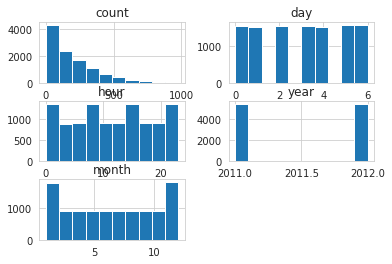

In [75]:
data_cpy.hist()

In [76]:
data_cpy

,season,holiday,workingday,weather,count,day,hour,year,month,windspeed type,temp type,humidity type,atemp type
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,16,5,0,2011,1,0,0,2,1
2011-01-01 01:00:00,1,0,0,1,40,5,1,2011,1,0,0,2,1
2011-01-01 02:00:00,1,0,0,1,32,5,2,2011,1,0,0,2,1
2011-01-01 03:00:00,1,0,0,1,13,5,3,2011,1,0,0,2,1
2011-01-01 04:00:00,1,0,0,1,1,5,4,2011,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,336,2,19,2012,12,1,1,1,1
2012-12-19 20:00:00,4,0,1,1,241,2,20,2012,12,1,1,2,1
2012-12-19 21:00:00,4,0,1,1,168,2,21,2012,12,1,1,2,1


## Neural Nets 

In [77]:
!pip install keras --no-cache-dir
!pip install tensorflow --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 176.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 227.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 160.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 211.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 215.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.10.0
    Uninstalling absl-py-0.10.0:
      Successfully uninstalled absl-py-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [78]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [79]:
scaled_X_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,hour,year,month
datetime,,,,,,,,,,,,
2011-09-03 12:00:00,0.449782,-0.174386,-1.457184,-0.657591,1.099889,1.064798,-0.040564,0.261225,0.986700,0.064375,-1.002530,0.725437
2012-08-02 17:00:00,0.449782,-0.174386,0.686255,-0.657591,1.732925,1.781054,-0.509316,0.503481,-0.011173,0.785468,0.997477,0.435861
2012-04-12 06:00:00,-0.444238,-0.174386,0.686255,-0.657591,-1.010231,-1.083971,0.167770,0.503481,-0.011173,-0.800937,0.997477,-0.722444
2011-06-19 19:00:00,-0.444238,-0.174386,-1.457184,-0.657591,1.205395,1.243862,0.011520,-0.467170,1.485637,1.073905,-1.002530,-0.143292
2012-02-03 04:00:00,-1.338258,-0.174386,0.686255,-0.657591,-1.221242,-1.263035,-0.092648,0.261225,0.487764,-1.089374,0.997477,-1.301596
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-15 13:00:00,1.343802,-0.174386,0.686255,2.523689,0.255841,0.259305,-0.092648,0.261225,-1.009046,0.208594,-1.002530,1.304589
2011-08-05 22:00:00,0.449782,-0.174386,0.686255,-0.657591,1.099889,1.064798,0.167770,0.261225,0.487764,1.506561,-1.002530,0.435861
2012-10-14 14:00:00,1.343802,-0.174386,-1.457184,-0.657591,0.888877,0.885734,-1.186403,1.838330,1.485637,0.352812,0.997477,1.015013


In [80]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01


def build_model():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer="normal", activation="relu"),
        Dropout(0.2),
        Dense(hidden_units2, kernel_initializer="normal", activation="relu"),
        Dropout(0.2),
        Dense(hidden_units3, kernel_initializer="normal", activation="relu"),
        Dense(1, kernel_initializer="normal", activation="linear")
    ])
    return model

model = build_model()
              

In [81]:
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[msle])

history = model.fit(
    scaled_X_train.values,
    y_train.values,
    epochs=10, batch_size=64,
    validation_split=0.2)

Epoch 1/10
109/109 [==============================] - 2s 9ms/step - loss: 1.6456 - mean_squared_logarithmic_error: 1.6444 - val_loss: 0.8831 - val_mean_squared_logarithmic_error: 0.8811
Epoch 2/10
109/109 [==============================] - 1s 7ms/step - loss: 0.8952 - mean_squared_logarithmic_error: 0.8947 - val_loss: 0.7290 - val_mean_squared_logarithmic_error: 0.7292
Epoch 3/10
109/109 [==============================] - 1s 7ms/step - loss: 0.6775 - mean_squared_logarithmic_error: 0.6774 - val_loss: 0.5200 - val_mean_squared_logarithmic_error: 0.5181
Epoch 4/10
109/109 [==============================] - 1s 7ms/step - loss: 0.5095 - mean_squared_logarithmic_error: 0.5096 - val_loss: 0.3697 - val_mean_squared_logarithmic_error: 0.3744
Epoch 5/10
109/109 [==============================] - 1s 7ms/step - loss: 0.4211 - mean_squared_logarithmic_error: 0.4210 - val_loss: 0.3079 - val_mean_squared_logarithmic_error: 0.3093
Epoch 6/10
109/109 [==============================] - 1s 7ms/step - lo

In [82]:
def plot_history(history, key):
    plt.plot(history.history[key]),
    plt.plot(history.history["val_"+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, "val_"+key])
    plt.show()


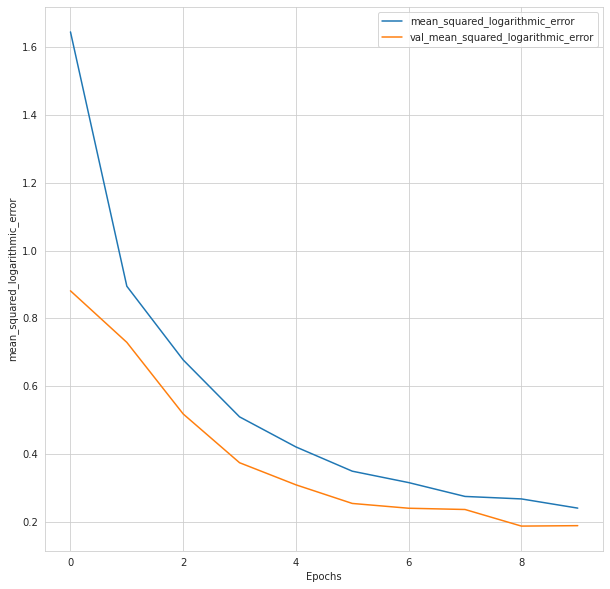

In [83]:
#Plot the history
plt.figure(figsize=(10, 10))
plot_history(history, "mean_squared_logarithmic_error")

In [84]:
test["count"] = model.predict(scaled_X_test)

203/203 [==============================] - 1s 3ms/step


In [85]:
test

,season,holiday,workingday,weather,day,hour,year,month,windspeed type,temp type,humidity type,atemp type,count
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,3,0,2011,1,1,1,2,1,5.200495
2011-01-20 01:00:00,1,0,1,1,3,1,2011,1,0,1,2,1,5.408269
2011-01-20 02:00:00,1,0,1,1,3,2,2011,1,0,1,2,1,3.510898
2011-01-20 03:00:00,1,0,1,1,3,3,2011,1,0,1,2,1,2.964657
2011-01-20 04:00:00,1,0,1,1,3,4,2011,1,0,1,2,1,4.374534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,0,19,2012,12,0,1,2,1,216.965027
2012-12-31 20:00:00,1,0,1,2,0,20,2012,12,0,1,2,1,145.183014
2012-12-31 21:00:00,1,0,1,1,0,21,2012,12,0,1,2,1,129.421097


### Submission

In [86]:
submission = test["count"].reset_index()

In [87]:
submission

,datetime,count
0,2011-01-20 00:00:00,5.200495
1,2011-01-20 01:00:00,5.408269
2,2011-01-20 02:00:00,3.510898
3,2011-01-20 03:00:00,2.964657
4,2011-01-20 04:00:00,4.374534
...,...,...
6488,2012-12-31 19:00:00,216.965027
6489,2012-12-31 20:00:00,145.183014
6490,2012-12-31 21:00:00,129.421097
6491,2012-12-31 22:00:00,98.022644


In [88]:
submission["count"].lt(0).sum().sum()

0

In [89]:
submission.to_csv("submission.csv", index=False)

In [90]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Neural Net submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 340kB/s]
Successfully submitted to Bike Sharing Demand

In [91]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1| head -n+10

fileName        date                 description                   status    publicScore  privateScore  
--------------  -------------------  ----------------------------  --------  -----------  ------------  
submission.csv  2023-06-13 12:54:38  Neural Net submission         pending                              
submission.csv  2023-06-13 12:53:36  third submission              complete  0.48501      0.48501       
submission.csv  2023-06-13 12:42:49  second raw submission         complete  0.43911      0.43911       
submission.csv  2023-06-12 16:35:16  xgb(wo hp tuning) submission  complete  0.52993      0.52993       
submission.csv  2023-06-12 15:57:34  Neural Net submission         complete  0.53373      0.53373       
submission.csv  2023-06-12 15:56:05  Neural Net submission         error                                
submission.csv  2023-06-12 15:54:23  Neural Net submission         error                                
submission.csv  2023-06-12 15:50:32  Neural Net submiss

## XGBoost (without hyperparameter tuning)

In [93]:
import xgboost as xgb

In [94]:
xgb_r = xgb.XGBRegressor(objective="reg:linear",
                         n_estimators=10, seed=123)

xgb_r.fit(scaled_X_train, y_train)

[12:55:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, ...)

In [95]:
pred = xgb_r.predict(scaled_X_test)

In [157]:
pred

array([ 13.153097,   5.752806,   3.508164, ..., 149.83221 ,  80.82946 ,
        47.04707 ], dtype=float32)

In [158]:
test["count_xgb"] = pred

In [159]:
submission = test["count_xgb"].reset_index()

In [160]:
submission.columns=["datetime", "count"]

In [161]:
submission["count"].lt(0).sum().sum()

54

In [162]:
submission["count"] = submission["count"].clip(lower=0)

In [163]:
submission.to_csv("submission.csv", index=False)

### Submission

In [164]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "xgb(wo hp tuning) submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 437kB/s]
Successfully submitted to Bike Sharing Demand

In [165]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description                     status    publicScore  privateScore  
--------------  -------------------  ------------------------------  --------  -----------  ------------  
submission.csv  2023-06-13 13:26:10  xgb(wo hp tuning) submission    complete  0.52993      0.52993       
submission.csv  2023-06-13 13:24:19  XGBoost (hp tuning) submission  error                                
submission.csv  2023-06-13 13:20:08  XGBoost (hp tuning) submission  error                                
submission.csv  2023-06-13 13:16:01  XGBoost (hp tuning) submission  error                                


## XGBoost with hyperparameter tuning

In [167]:
from sklearn.model_selection import GridSearchCV

In [168]:
xgb_r_ht = xgb.XGBRegressor()
parameters = {"nthread":[4],
               "objective":["reg:linear"],
               "learning_rate":[0.03, 0.05, 0.07],
               "max_depth":[5, 6, 7],
               "min_chidl_weight":[4],
               "silent":[1],
               "subsample":[0.7],
               "colsample_bytree":[0.7],
               "n_estimators":[500]}

xgb_grid = GridSearchCV(xgb_r_ht, parameters, cv=2, n_jobs=-1, verbose=True)

xgb_grid.fit(scaled_X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[13:27:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:15] WARNING: ../src/learner.cc:627: 
Parameters: { "min_chidl_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [169]:
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)


{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_chidl_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_chidl_weight=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', predictor='auto', ...)


In [193]:
xgb_r_w_hpt = xgb.XGBRegressor(colsample_bytree = 0.7, 
                               learning_rate = 0.03, 
                               max_depth =  7, 
                               min_child_weight= 4, n_estimators = 500,
                               nthread= 4, 
                               objective ="reg:linear",
                               silent = 1, subsample = 0.7)

In [194]:
xgb_r_w_hpt.fit(scaled_X_train, y_train)

[13:41:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:20] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, ...)

In [195]:
preds = xgb_r_w_hpt.predict(scaled_X_test)

In [196]:
preds

array([ 18.899801 ,   4.036034 ,   2.3132868, ..., 137.6261   ,
        92.55802  ,  45.586296 ], dtype=float32)

In [197]:
test["count_xgb_best_params"] = preds

In [198]:
submission = test["count_xgb_best_params"].reset_index()

In [199]:
submission.columns=["datetime", "count"]

In [200]:
submission["count"].lt(0).sum().sum()

142

In [201]:
submission["count"] = submission["count"].clip(lower=0)

In [202]:
submission

,datetime,count
0,2011-01-20 00:00:00,18.899801
1,2011-01-20 01:00:00,4.036034
2,2011-01-20 02:00:00,2.313287
3,2011-01-20 03:00:00,2.919256
4,2011-01-20 04:00:00,2.575870
...,...,...
6488,2012-12-31 19:00:00,280.775879
6489,2012-12-31 20:00:00,173.914490
6490,2012-12-31 21:00:00,137.626099
6491,2012-12-31 22:00:00,92.558022


In [203]:
submission.to_csv("submission.csv", index=False)

### Submission

In [204]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "XGBoost (hp tuning) submission"

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 405kB/s]
Successfully submitted to Bike Sharing Demand

In [207]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 115

fileName        date                 description                     status    publicScore  privateScore  
--------------  -------------------  ------------------------------  --------  -----------  ------------  
submission.csv  2023-06-13 13:42:02  XGBoost (hp tuning) submission  complete  0.57673      0.57673       
submission.csv  2023-06-13 13:37:24  XGBoost (hp tuning) submission  complete  0.57420      0.57420       
submission.csv  2023-06-13 13:35:30  XGBoost (hp tuning) submission  complete  0.57420      0.57420       
submission.csv  2023-06-13 13:35:20  XGBoost (hp tuning) submission  complete  0.57420      0.57420       
submission.csv  2023-06-13 13:28:56  XGBoost (hp tuning) submission  error                                
submission.csv  2023-06-13 13:26:10  xgb(wo hp tuning) submission    complete  0.52993      0.52993       
submission.csv  2023-06-13 13:24:19  XGBoost (hp tuning) submission  error                                
submission.csv  2023-06-13 13:20:08  

# Lineplots for top 3 models

In [218]:
def plot(y_actual, y_pred, algo, t_from, t_to):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    axes.plot(y_actual[, label="Actual", marker=".", markersize=12)
    axes.plot(y_pred, label="Predicted", marker=".", markersize=12)
    axes.set(xlabel="Time", ylabel="Count", title=f"{algo} Model")
    axes.legend()
    
    plt.show()

## Lineplot for AutoGLuon Model

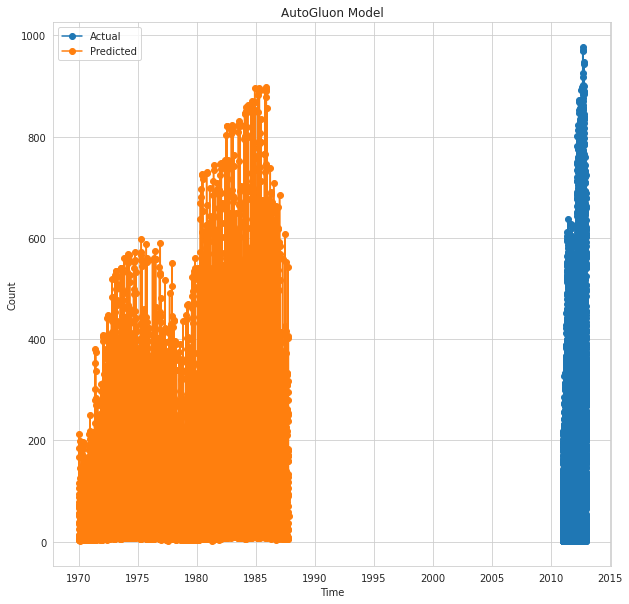

In [219]:
plot(data_cpy["count"], predictions["count"], algo="AutoGluon")